In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import build_vocab
from torchlake.sequence_data.controller.trainer_seq2seq import Seq2SeqTrainer
from torchlake.text_generation.datasets.flickr import Flickr8k, Flickr8kFromLMDB
from torchlake.text_generation.models.show_and_tell import NeuralImageCation
from torchtext.data.utils import get_tokenizer
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.controller.recorder import TrainRecorder
import torchtext.transforms as T
from tqdm import tqdm
from pathlib import Path

To utilize this notebook, you have to install `spacy` and download `de_core_news_sm` and `en_core_web_sm` first

# setting

In [3]:
data_path = Path("F://data/flickr8k")
data_path.mkdir(exist_ok=True)

artifacts_path = Path("../../artifacts/show-and-tell")
artifacts_path.mkdir(exist_ok=True)

In [4]:
BATCH_SIZE = 128
MAX_SEQ_LEN = 32
CONTEXT = NlpContext(max_seq_len=MAX_SEQ_LEN)

In [5]:
DEVICE = torch.device(CONTEXT.device)

# data

In [6]:
tokenizer = get_tokenizer('spacy', language='en')  # en_web_core_sm

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [7]:
IMAGE_SIZE = 224

In [8]:
image_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # extractor will do imagenet normalization, so skip it here
        A.Normalize(0, 1), 
        ToTensorV2(),
    ]
)

In [9]:
# only keep for remind me of how to use official dataset

# import joblib
# from torchvision.datasets import Flickr8k

# cache_path =  Path("./cache")

# if cache_path.exists():
#     train_iter = joblib.load(cache_path.as_posix())
# else:      
#     # sloooooooooooooooow
#     train_iter = Flickr8k(
#         data_path.joinpath("Images"),
#         data_path.joinpath("8k-pictures.html"),
#         transform=image_transform,
#     )
#     joblib.dump(train_iter, cache_path.as_posix())  

In [10]:
# train_iter = Flickr8k(
#     data_path.joinpath("Images"),
#     data_path.joinpath("captions.txt"),
# )

In [11]:
# for i, (img, text) in enumerate(train_iter):
#     print(img.shape, text)
    
#     if i > 5:
#         break

In [12]:
# train_iter.annotations

In [13]:
# create lmdb one
# import lmdb

# env = lmdb.Environment(
#     data_path.joinpath("flickr8k").as_posix(),
#     map_size=1<<33, # 8GB
# )
# train_iter = Flickr8k(
#     data_path.joinpath("Images"),
#     data_path.joinpath("captions.txt"),
# )

# train_iter.to_lmdb(env)

In [14]:
# env.close()

In [15]:
train_iter = Flickr8kFromLMDB(
    data_path.joinpath("flickr8k").as_posix(),
)

(array([1.700e+01, 4.600e+01, 2.370e+02, 1.843e+03, 2.683e+03, 3.397e+03,
        8.101e+03, 4.342e+03, 4.070e+03, 3.639e+03, 5.545e+03, 1.830e+03,
        1.372e+03, 1.736e+03, 5.100e+02, 3.430e+02, 3.770e+02, 1.240e+02,
        7.600e+01, 6.000e+01, 5.700e+01, 1.100e+01, 1.000e+01, 1.900e+01,
        2.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 2. ,  3.3,  4.6,  5.9,  7.2,  8.5,  9.8, 11.1, 12.4, 13.7, 15. ,
        16.3, 17.6, 18.9, 20.2, 21.5, 22.8, 24.1, 25.4, 26.7, 28. , 29.3,
        30.6, 31.9, 33.2, 34.5, 35.8, 37.1, 38.4, 39.7, 41. ]),
 <BarContainer object of 30 artists>)

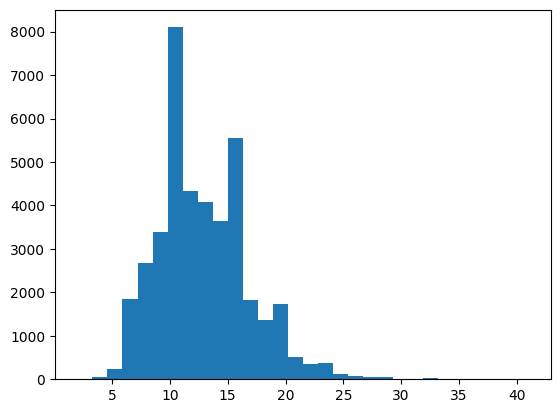

In [16]:
sentence_lengths = [len(tokenizer(text)) for _, text in train_iter]
plt.hist(sentence_lengths, bins=30)

In [17]:
vocab = build_vocab(
    map(lambda pair: tokenizer(pair[1].lower().strip()), train_iter),
    CONTEXT,
)

In [18]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

3102

In [19]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [20]:
def text_pipeline(corpus: str) -> list[torch.Tensor]:
    x = corpus.lower().strip()
    x = tokenizer(x)
    x = text_transform(x)
    return x

In [21]:
train_iter.env.close()

In [22]:
# 1GB
# train_iter = Flickr8k(
#     data_path.joinpath("Images"),
#     data_path.joinpath("captions.txt"),
#     image_transform,
#     text_pipeline,
# )

In [23]:
train_iter = Flickr8kFromLMDB(
    data_path.joinpath("flickr8k").as_posix(),
    image_transform,
    text_pipeline,
)

In [24]:
for imgs, caption in train_iter:
    print(imgs.shape, caption.shape)
    break

torch.Size([3, 224, 224]) torch.Size([32])


In [25]:
# def collate_fn(batch):
#     image_batch, label_batch = [], []

#     for x, y in batch:
#         y = text_pipeline(y)
#         for yi in y:
#             image_batch.append(x)
#             label_batch.append(yi)

#     return torch.stack(image_batch), torch.stack(label_batch)

In [26]:
NUM_WORKERS = get_num_workers()

In [27]:
train_loader = DataLoader(
    train_iter,
    batch_size=BATCH_SIZE,
    # collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True,
)

# test_loader = DataLoader(
#     val_iter,
#     batch_size=BATCH_SIZE,
#     collate_fn=collate_fn,
#     num_workers=NUM_WORKERS,
    # pin_memory=True,
# )

In [28]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 224, 224]) torch.Size([128, 32])


# Model

In [29]:
from functools import partial

In [30]:
from torchlake.common.models import VGGFeatureExtractor

extractor = VGGFeatureExtractor("vgg16", "relu", trainable=False)
extractor.forward = partial(extractor.forward, target_layer_names=["5_3"])

In [31]:
# from torchlake.common.models import ResNetFeatureExtractor

# extractor = ResNetFeatureExtractor("resnet50", "block", trainable=False)
# extractor.forward = partial(extractor.forward, target_layer_names=["4_1"])

In [32]:
from torchlake.sequence_data.models.base import RNNGenerator
from torchlake.sequence_data.models.lstm import LSTMDiscriminator

decoder = RNNGenerator(
    LSTMDiscriminator(
        VOCAB_SIZE,
        embed_dim=512,
        hidden_dim=256,
        output_size=VOCAB_SIZE,
        num_layers=4,
        bidirectional=True,
        context=CONTEXT,
    )
)

In [33]:
model = NeuralImageCation(
    extractor,
    decoder,
    context=CONTEXT,
).to(DEVICE)

In [34]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
NeuralImageCation                             --
├─VGGFeatureExtractor: 1-1                    --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15                      (590,080)
│    │    └─ReLU: 3

# Training

In [35]:
EPOCHES = 10

In [36]:
trainer = Seq2SeqTrainer(EPOCHES, DEVICE, feature_last=True)
trainer.set_curriculum_strategy("inverse_sigmoid", k=5)

In [37]:
criterion = nn.CrossEntropyLoss(ignore_index=CONTEXT.padding_idx, reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [38]:
recorder = TrainRecorder(total_epoch=EPOCHES)
recorder.increment_data_size(len(train_iter))

In [39]:
recorder.data_size

40455

In [40]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [41]:
scaler = torch.cuda.amp.GradScaler()

In [42]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    recorder=recorder,
    scaler=scaler,
)

Enable AMP: True
Training...


100%|██████████| 317/317 [02:45<00:00,  1.91it/s]


Epoch 1 : 63.121591025467815 (0%)


100%|██████████| 317/317 [02:40<00:00,  1.97it/s]


Epoch 2 : 48.5757386483511 (-23%)


100%|██████████| 317/317 [02:37<00:00,  2.01it/s]


Epoch 3 : 43.97513114222936 (-9%)


100%|██████████| 317/317 [02:37<00:00,  2.01it/s]


Epoch 4 : 41.09008638492519 (-7%)


100%|██████████| 317/317 [02:33<00:00,  2.06it/s]


Epoch 5 : 38.9381142003002 (-5%)


100%|██████████| 317/317 [02:36<00:00,  2.02it/s]


Epoch 6 : 37.334614550352754 (-4%)


100%|██████████| 317/317 [02:44<00:00,  1.92it/s]


Epoch 7 : 36.03133147299445 (-3%)


100%|██████████| 317/317 [02:28<00:00,  2.14it/s]


Epoch 8 : 34.875204259947644 (-3%)


100%|██████████| 317/317 [02:23<00:00,  2.21it/s]


Epoch 9 : 33.77197067794452 (-3%)


100%|██████████| 317/317 [02:25<00:00,  2.18it/s]

Epoch 10 : 32.722271495796 (-3%)


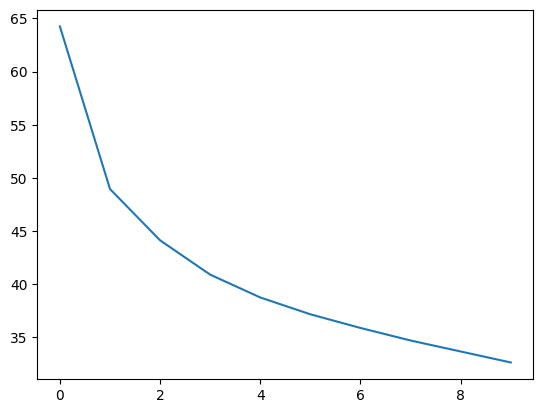

In [69]:
plt.plot(training_loss)

# Save

In [ ]:
model_path = artifacts_path.joinpath("show-and-tell.vgg16.pth")

In [44]:
torch.save(model.state_dict(), model_path.as_posix())

In [45]:
get_file_size(model_path)

'92.34MiB'

In [41]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# Evaluate

## BLEU score

In [46]:
VAL_BATCH_SIZE = 125

In [47]:
val_loader = DataLoader(
    train_iter,
    batch_size=VAL_BATCH_SIZE,
    # collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
)

In [48]:
from torchmetrics.text import BLEUScore

In [49]:
metric = BLEUScore()

In [50]:
model.eval()
running_loss = 0.0
data_count = 0
with torch.no_grad():
    for imgs, captions in tqdm(val_loader):
        gts = [[] for _ in range(imgs.size(0) // 5)]
        data_count += len(imgs)

        # list of strings
        # i.e. list of candidates
        for i, t in enumerate(captions.tolist()):
            caption = vocab.lookup_tokens(t)
            try:
                start_idx, end_idx = caption.index(CONTEXT.bos_str), caption.index(
                    CONTEXT.eos_str
                )
            except:
                start_idx, end_idx = 0, -1
            gts[i // 5].append(" ".join(caption[start_idx + 1 : end_idx]))

        # if data_count % 5 == 0:
        imgs = imgs.to(DEVICE)
        outputs = model.predict(imgs, topk=1)

        # list of string
        preds = []
        for o in outputs[::5].tolist():
            output = vocab.lookup_tokens(o)
            try:
                start_idx, end_idx = output.index(CONTEXT.bos_str), output.index(
                    CONTEXT.eos_str
                )
            except:
                start_idx, end_idx = 0, -1
            preds.append(" ".join(output[start_idx + 1 : end_idx]))

        assert len(gts) == imgs.size(0) // 5
        assert len(preds) == imgs.size(0) // 5

        metric.update(preds, gts)

        # if data_count >= 5:
        #     break

100%|██████████| 324/324 [02:21<00:00,  2.28it/s]


In [ ]:
metric.compute()

tensor(0.2437)

## Compare to groundtruth

In [58]:
from torchlake.common.utils.convert import img_tensor_to_np

CLIP = 5

imgs = []
titles = []
model.eval()
with torch.no_grad():
    for i, (img_batch, text_batch) in enumerate(train_loader):
        # ori_source, ori_target = img, text
        # img = img.unsqueeze(0)
        img_batch = img_batch.to(DEVICE)
        # collect imgs
        imgs = img_tensor_to_np(img_batch[:CLIP])
        
        # text = text.unsqueeze(0)
        # text_batch = text_batch.to(DEVICE)
        
        # output = model.predict(img_batch, topk=2)[0]
        outputs = model.predict(img_batch, topk=1)
        
        # if EOS_IDX in outputs:
        
        for j in range(CLIP):
            output = outputs[j].tolist()
            output = vocab.lookup_tokens(output)
            start_idx, end_idx = output.index(CONTEXT.bos_str), output.index(CONTEXT.eos_str)
            output_tokens = output[start_idx+1:end_idx]
            
            target = text_batch[j].tolist()
            target_tokens = vocab.lookup_tokens(target)
            target_start_idx, target_end_idx = target_tokens.index(CONTEXT.bos_str), target_tokens.index(CONTEXT.eos_str)
            target_tokens = target_tokens[target_start_idx+1:target_end_idx]
            
            # collect tokens
            titles.append(" ".join(output_tokens))
            
            print(f'第{j+1}句')
            print('target:', *target_tokens, sep=' ')
            print('output:', *output_tokens, sep=' ')
        
        # if i+1==CLIP: break
        break

第1句
target: b'a woman and a little girl are playing with a ball in the pool underneath some water <unk> . '
output: b'a boy and a boy are in a pool . '
第2句
target: b'an elderly gentleman very <unk> dressed . '
output: b'a man in a black jacket and a blue hat . '
第3句
target: b'a tan and white dog jumping after a red frisbee . '
output: b'a white dog is running through the grass . '
第4句
target: b'a kid walks on a snowy hill with their arms out . '
output: b'a child in a red jacket is skiing on a snowy hill . '
第5句
target: b'a black dog has just jumped into a swimming pool . '
output: b'a black dog is swimming in a pool . '


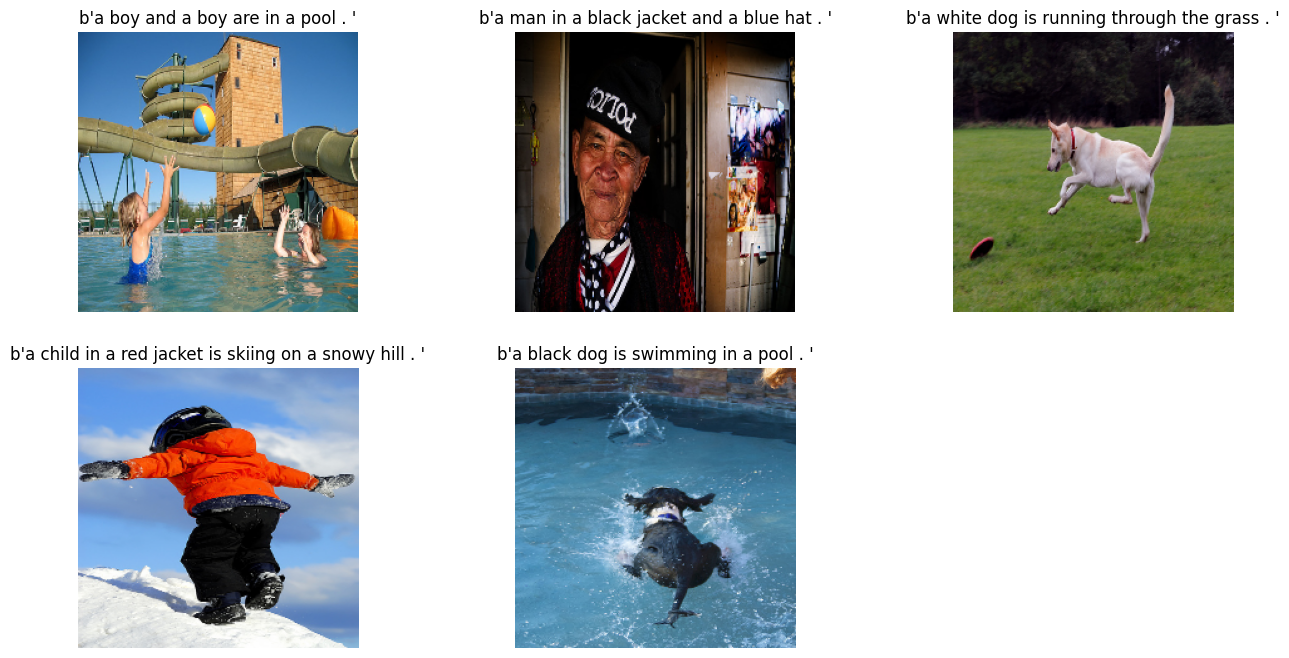

In [59]:
from torchlake.common.utils.plot import plot_grids

plot_grids(
    imgs,
    titles,
    num_row=2,
    num_col=3,
    figsize=(16, 8),
)

## In the wild

In [60]:
from torchlake.common.utils.image import load_image

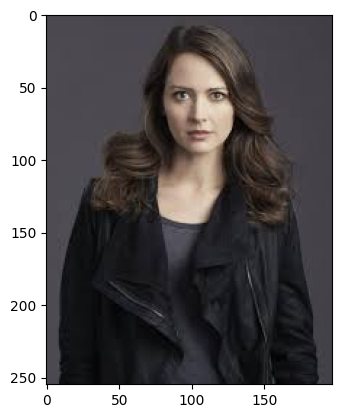

In [61]:
imgs = load_image("../../data/contents/black-woman.jpg", is_numpy=True)
plt.imshow(imgs)

In [70]:
model.eval()
with torch.no_grad():
    t_img = image_transform(image=imgs)["image"]
    t_img = t_img.unsqueeze(0).to(DEVICE)
    
    caption = model(t_img, topk=5)

In [41]:
output = vocab.lookup_tokens(caption[0].tolist())
end_index = output.index(CONTEXT.eos_str)

print(*output[1:end_index], sep=" ")

b'the woman in a white shirt and black jacket . . '
